- performance evaluation
- date: 2020-08-06
- maintainer: YZK

In [ ]:
# jupyter nbconvert --to script perfeval.ipynb

In [110]:
import logging
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import norm
from scipy import stats as stats
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error

plt.style.use('ggplot')


In [111]:

class perfeval:
    
    @staticmethod
    def tspredict(y_true, y_pred, outd=None, **kwarg):

        if not isinstance(y_true, np.ndarray):
            y_true = np.array(y_true)

        if not isinstance(y_pred, np.ndarray):
            y_pred = np.array(y_pred)

        assert y_true.shape[0] == y_pred.shape[0]

        ###  config
        props = dict(boxstyle="round", facecolor="red", alpha=0.5)

        xposi_ = None
        if "xposi" in kwarg.keys():
            xposi_ = kwarg["xposi"]

        xlabel_ = None
        if "xlabel" in kwarg.keys():
            xlabel_ = kwarg["xlabel"]

        title_ = None
        if "title" in kwarg.keys():
            title_ = kwarg["title"]

        ###  preprocessing    
        minv = min(np.min(y_true), np.min(y_pred))
        maxv = max(np.max(y_true), np.max(y_pred))

        residual_ = y_pred - y_true
        nsize = len(residual_)
        rmse = (np.apply_along_axis(lambda x: x**2, 0, residual_).mean() / nsize)**0.5
        mu_  = residual_.mean()
        std_ = residual_.std(ddof=1)

        ###  normality test
        # the null hypothesis that the data was drawn from a normal distribution.
        stests, stestp = stats.shapiro(residual_)

        # the null hypothesis that a sample comes from a normal distribution.
        ntests, ntestp = stats.normaltest(residual_)

        descstat = "($\mu$, $\sigma$) = ({0:7.3f}, {1:7.3f})\n(shapiro, ntest) = ({2:7.3f}, {3:7.3f})".format(mu_, std_, stestp, ntestp)

        plt.figure(figsize=(16, 10))

        logging.info("tspredict-fig1")
        ax1 = plt.subplot2grid(shape=(7, 4), loc=(0, 0), rowspan=3, colspan=4)

        ax1.plot(y_true, label="$y_{true}$") 
        ax1.plot(y_pred, label="$\hat{y}_{pred}$")

        if (xposi_ is not None) and (xlabel_ is not None):
            assert len(xposi_) == len(xlabel_)
            ax1.set_xticks(xposi_)    
            ax1.set_xticklabels(xlabel_)    

        if title_ is not None:
            plt.title(title_)

        ax1.legend(fontsize=14)

        logging.info("tspredict-fig2")
        ax2 = plt.subplot2grid(shape=(7, 4), loc=(3, 0), rowspan=2, colspan=4)
        ax2.plot(residual_, label="residual", color="blue")
        ax2.plot(np.zeros(nsize), "--", color="red")

        if (xposi_ is not None) and (xlabel_ is not None):
            ax2.set_xticks(xposi_)    
            ax2.set_xticklabels(xlabel_)   

        ax2.legend(fontsize=14)

        ax2.text(nsize, min(residual_), "RMSE = {0:>7.3f}".format(rmse),
                 verticalalignment="bottom", horizontalalignment="right",
                 color="black", fontsize=14, bbox=props)

        logging.info("tspredict-fig3-error.dist")
        ax3 = plt.subplot2grid(shape=(7, 4), loc=(5, 0), rowspan=2, colspan=2)
        n, bins, patches = ax3.hist(residual_, bins=30, density=True, stacked=True, label="residual", facecolor="g", alpha=0.75)
        resx = np.arange(min(residual_), max(residual_), 0.001)
        resnpdf = norm(mu_, std_).pdf(resx)
        ax3.plot(resx, resnpdf, label="normal", color="red")
        ax3.text(bins[int(len(bins) * 0.05)], max(n) * 0.8, s=descstat, fontsize=14, bbox=props)
        ax3.legend(fontsize=14)

        logging.info("tspredict-fig4")
        ax4 = plt.subplot2grid(shape=(7, 4), loc=(5, 2), rowspan=2, colspan=2)
        ax4.scatter(y_true, y_pred, label="residual", color="skyblue")
        ax4.plot([minv, maxv], [minv, maxv], "--", color="red")

        plt.tight_layout()

        if outd is not None:
            outf = "{}/perfeval.png".format(outd)
            if title_ is not None:
                outf = "{}/perfeval_{}.png".format(outd, title_)

            logging.info("tspredict".format(outf))
            plt.savefig(outf)
        else:
            plt.show()

        plt.close()

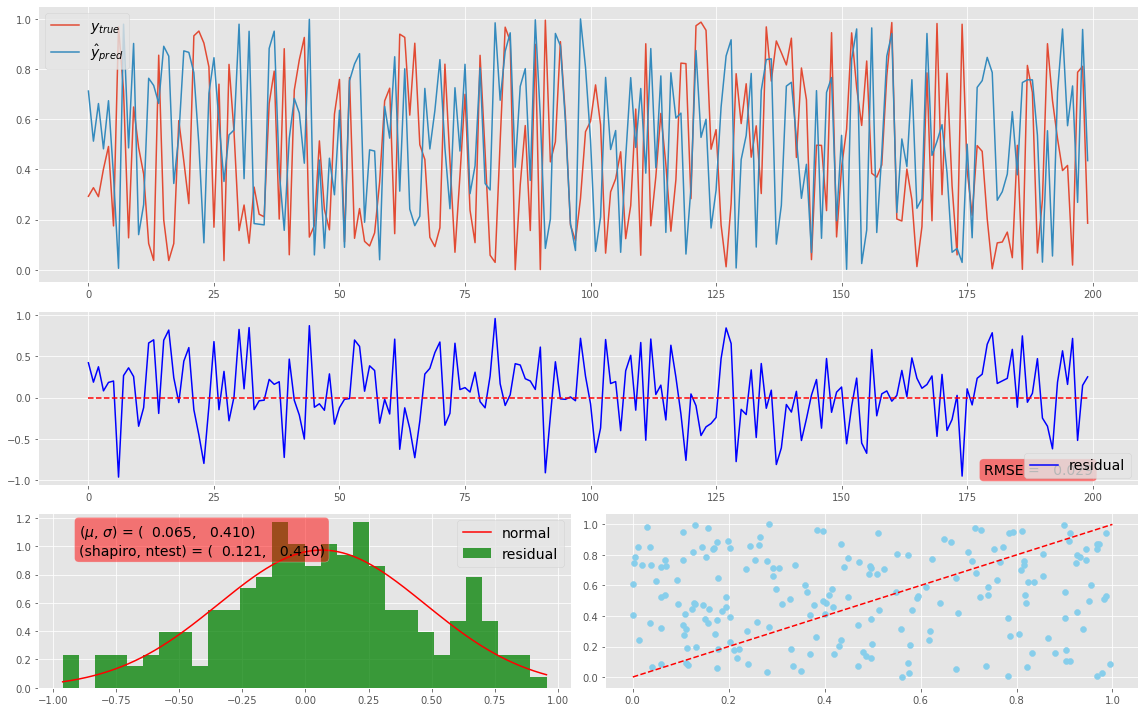

In [112]:

if __name__ == "__main__":

    y_true = np.random.random_sample(200)
    y_pred = np.random.random_sample(200)

    perfeval.tspredict(y_true, y_pred)
